# VQ VAE on CelebA
Training model and PixelCNN Sampler

Phase 1: Train VQVAE

Phase 2: Train PixelCNN

Phase 3: Sample images


Note: After some attemps I see that the model produce images a little bit blurry to i chose to make it deeper

## Phase 1: Train The variational Autoencoder

In [54]:
import itertools
import os
import sys

from classes.VQVAE import VQVAE
from classes.PixelCNN import PixelCNN,TfDistPixelCNN
from utils.callbacks import WandbImagesVQVAE, Save_VQVAE_Weights, Save_PixelCNN_Weights
from utils.functions import  map_vqvae_weights,pixelcnn_sample_vqvae
from imutils import build_montages


import tensorflow as tf
from tensorflow import keras
import numpy as np
import wandb
from wandb.keras import WandbCallback
from tensorflow.data import AUTOTUNE

import argparse
from os.path import join as opj
from imutils import paths
import tqdm
import glob
import json

In [5]:
#set the first GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

print(os.environ.get("CUDA_VISIBLE_DEVICES"))

0


In [6]:
wandb.login()
#phase="VQ_VAE_Training"          #change
phase="PixelCNN_Training"

config={"dataset":"celebA", "type":"VQ-VAE","phase":phase}

images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba" #local
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


In [7]:
BS = 64
EPOCHS=40
INIT_LR=1e-4

config["BS"]=BS
config["EPOCHS"]=EPOCHS
config["INIT_LR"]=INIT_LR

## Dataloaders

In [8]:
def load_images(imagePath):
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128)) / 255.0

    #eventually load other information like attributes here
    
    # return the image and the extra info
    
    
    return image

In [9]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(images_dir))


train_len=int(0.8*len(imagePaths))
val_len=int(0.1*len(imagePaths))
test_len=int(0.1*len(imagePaths))

train_imgs=imagePaths[:train_len]                                #      80% for training
val_imgs=imagePaths[train_len:train_len+val_len]                 #      10% for validation
test_imgs=imagePaths[train_len+val_len:]                         #      10% for testing

print(f"[TRAINING]\t {len(train_imgs)}\n[VALIDATION]\t {len(val_imgs)}\n[TEST]\t\t {len(test_imgs)}")

[INFO] loading image paths...
[TRAINING]	 138545
[VALIDATION]	 17318
[TEST]		 17319


In [10]:
#TRAINING 

train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs)
train_dataset = (train_dataset
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

ts=len(train_imgs)//BS

##VALIDATION

val_dataset = tf.data.Dataset.from_tensor_slices(val_imgs)
val_dataset = (val_dataset
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

vs=len(val_imgs)//BS

## TEST

test_dataset = tf.data.Dataset.from_tensor_slices(test_imgs)
test_dataset = (test_dataset
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

## Model Definition

In [11]:
print(f"[INFO] Training VQ_VAE Model")

encoder_architecture=[(1,64),(1,128),(1,256),(3,256)]
decoder_architecture=[(3,256),(1,256),(1,128),(1,64)]
input_shape=(128,128,3)
latent_dim=512
num_embeddings=256


config["encoder_architecture"]=encoder_architecture
config["decoder_architecture"]=decoder_architecture
config["latent_dim"]=latent_dim
config["num_embeddings"]=num_embeddings
config["input_shape"]=input_shape

g=VQVAE(input_shape,latent_dim=latent_dim,num_embeddings=num_embeddings,train_variance=4,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture)

print(g.encoder.summary())

print(g.decoder.summary())


[INFO] Training VQ_VAE Model
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv_res_block (ConvResBlock (None, 64, 64, 64)        80320     
_________________________________________________________________
conv_res_block_1 (ConvResBlo (None, 32, 32, 128)       386560    
_________________________________________________________________
conv_res_block_2 (ConvResBlo (None, 16, 16, 256)       1543168   
_________________________________________________________________
conv_res_block_3 (ConvResBlo (None, 8, 8, 256)         4334080   
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 512)         131584    
Total params: 6,475,712
Trainable params: 6,470,848
Non-trainable params: 4,864
________________

# Phase 1: Train the VQ-VAE model

## Callbacks

In [19]:
wandb.init(project="TorVergataExperiment-Generative",config=config)

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [21]:
os.makedirs("models/vqvae_celeba",exist_ok=True)
model_check= Save_VQVAE_Weights("models/vqvae_celeba")



es=tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


callbacks=[
    WandbImagesVQVAE(test_dataset,sample=False),
    WandbCallback(),
    model_check,
    es,
]


## COMPILE AND TRAIN

In [22]:
g.compile(keras.optimizers.Adam(INIT_LR))


In [23]:
g.fit(train_dataset,validation_data=val_dataset,steps_per_epoch=ts,validation_steps=vs,epochs=EPOCHS,callbacks=callbacks)


Epoch 1/40
2164/2164 [==============================] - 706s 323ms/step - loss: 0.0340 - reconstruction_loss: 0.0050 - vqvae_loss: 0.0260 - val_val_reconstruction_loss: 0.0030
Epoch 2/40
2164/2164 [==============================] - 667s 308ms/step - loss: 0.0080 - reconstruction_loss: 0.0028 - vqvae_loss: 0.0050 - val_val_reconstruction_loss: 0.0025
Epoch 3/40
2164/2164 [==============================] - 645s 298ms/step - loss: 0.0066 - reconstruction_loss: 0.0025 - vqvae_loss: 0.0041 - val_val_reconstruction_loss: 0.0022
Epoch 4/40
2164/2164 [==============================] - 645s 298ms/step - loss: 0.0061 - reconstruction_loss: 0.0023 - vqvae_loss: 0.0037 - val_val_reconstruction_loss: 0.0021
Epoch 5/40
2164/2164 [==============================] - 645s 298ms/step - loss: 0.0057 - reconstruction_loss: 0.0022 - vqvae_loss: 0.0036 - val_val_reconstruction_loss: 0.0020
Epoch 6/40
2164/2164 [==============================] - 653s 302ms/step - loss: 0.0055 - reconstruction_loss: 0.0021 - v

# Phase 2: Train the PixelCNN sampler



In [12]:
def map_models_weights(model_dir):
    files=os.listdir(model_dir)
    d={}
    for f in files:
        if "encoder" in f:
            d["encoder"]=opj(model_dir,f)
        elif ("generator" in f) or ("decoder" in f):
            d["decoder"]=opj(model_dir,f)
        elif "embeddings" in f:
            d["embeddings"]=opj(model_dir,f)
    return d


In [13]:

#model=VQVAE((28,28,1),latent_dim=16,num_embeddings=128,train_variance=4)

weights=map_models_weights("models/vqvae_celeba")

print(weights)
g.load_weights(weights["encoder"],weights["embeddings"],weights["decoder"])


BS=64

{'encoder': 'models/vqvae_celeba/vq_vae_encoder.h5', 'decoder': 'models/vqvae_celeba/vq_vae_decoder.h5', 'embeddings': 'models/vqvae_celeba/vq_vae_embeddings.npy'}


## Using smaller batch size while predict

A memory bug?

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs)
train_dataset = (train_dataset
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

ts=len(train_imgs)//BS

##VALIDATION

val_dataset = tf.data.Dataset.from_tensor_slices(val_imgs)
val_dataset = (val_dataset
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

In [15]:
encoded_outputs=[]

for batch in tqdm.tqdm(train_dataset):
    encoded_outputs.append(g.encoder.predict_on_batch(batch))

#encoded_outputs = g.encoder.predict(train_dataset)


100%|██████████| 2165/2165 [14:10<00:00,  2.55it/s]


In [16]:
encoded_outputs[0][0].shape

(8, 8, 512)

In [17]:
codebook_indices=[]
for b in tqdm.tqdm(range(len(train_dataset))):

    #flat the outputs
    batch_encoded=np.array(encoded_outputs[b])
    flat_enc_outputs=batch_encoded.reshape(-1,batch_encoded.shape[-1])
    code_index=g.vq_layer.get_code_indices(flat_enc_outputs).numpy()
    codebook_indices.append(list(code_index))




100%|██████████| 2165/2165 [07:50<00:00,  4.60it/s]


In [18]:
codebook_indices = list(itertools.chain.from_iterable(codebook_indices))
codebook_indices = np.array(codebook_indices)
print(codebook_indices.shape)

square_dim=batch_encoded.shape[1]

codebook_indices = codebook_indices.reshape(-1,square_dim,square_dim)
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

input_shape=(codebook_indices.shape[1],codebook_indices.shape[2])

(8866880,)
Shape of the training data for PixelCNN: (138545, 8, 8)


In [41]:
pixel_cnn = PixelCNN(input_dim=input_shape, n_embeddings=256, n_residual=5, n_convlayer=3)
opt = keras.optimizers.Adam(3e-3)
pixel_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=opt,metrics="accuracy")

wandb.init(project="TorVergataExperiment-Generative",config=config)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 8, 8)]            0         
_________________________________________________________________
tf.one_hot_7 (TFOpLambda)    (None, 8, 8, 256)         0         
_________________________________________________________________
pixel_conv_layer_21 (PixelCo (None, 8, 8, 128)         1605760   
_________________________________________________________________
residual_block_19 (ResidualB (None, 8, 8, 128)         98624     
_________________________________________________________________
residual_block_20 (ResidualB (None, 8, 8, 128)         98624     
_________________________________________________________________
residual_block_21 (ResidualB (None, 8, 8, 128)         98624     
_________________________________________________________________
residual_block_22 (ResidualB (None, 8, 8, 128)         9862

epoch,2
loss,3.35581
accuracy,0.13274
val_loss,3.35721
val_accuracy,0.133
_runtime,144
_timestamp,1638192633
_step,2
best_val_loss,3.35721
best_epoch,2


epoch,▁▅█
loss,█▃▁
accuracy,▁▇█
val_loss,█▂▁
val_accuracy,▁▅█
_runtime,▁▄█
_timestamp,▁▄█
_step,▁▅█


In [42]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
callbacks = [WandbCallback(), es]


In [43]:
pixel_cnn_dir="models/vqvae_celeba/pixelcnn"
os.makedirs(pixel_cnn_dir,exist_ok=True)

pixel_cnn.save_dict(opj(pixel_cnn_dir,"dict.json"))

pixel_cnn.fit(codebook_indices, codebook_indices, batch_size=BS, validation_split=0.1, epochs=30,
              callbacks=callbacks)
pixel_cnn.model.save_weights(opj(pixel_cnn_dir,"pixelcnn_vqvae_celeba_weights.h5"))



Epoch 1/30
1949/1949 [==============================] - 75s 36ms/step - loss: 3.7590 - accuracy: 0.0974 - val_loss: 3.4806 - val_accuracy: 0.1314


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/30
1949/1949 [==============================] - 65s 33ms/step - loss: 3.4665 - accuracy: 0.1329 - val_loss: 3.4473 - val_accuracy: 0.1357
Epoch 3/30
1949/1949 [==============================] - 61s 31ms/step - loss: 3.4349 - accuracy: 0.1379 - val_loss: 3.4309 - val_accuracy: 0.1384
Epoch 4/30
1949/1949 [==============================] - 61s 31ms/step - loss: 3.4211 - accuracy: 0.1397 - val_loss: 3.4262 - val_accuracy: 0.1386
Epoch 5/30
1949/1949 [==============================] - 62s 32ms/step - loss: 3.4099 - accuracy: 0.1417 - val_loss: 3.4192 - val_accuracy: 0.1396
Epoch 6/30
1949/1949 [==============================] - 60s 31ms/step - loss: 3.4013 - accuracy: 0.1423 - val_loss: 3.4163 - val_accuracy: 0.1397
Epoch 7/30
1949/1949 [==============================] - 64s 33ms/step - loss: 3.3982 - accuracy: 0.1435 - val_loss: 3.4124 - val_accuracy: 0.1408
Epoch 8/30
1949/1949 [==============================] - 57s 29ms/step - loss: 3.3922 - accuracy: 0.1442 - val_loss: 3.4113 -

# Phase 3: Sample the VQ VAE

In [44]:
weights=map_models_weights("models/vqvae_celeba")

print(weights)
g.load_weights(weights["encoder"],weights["embeddings"],weights["decoder"])

BS=64



{'encoder': 'models/vqvae_celeba/vq_vae_encoder.h5', 'decoder': 'models/vqvae_celeba/vq_vae_decoder.h5', 'embeddings': 'models/vqvae_celeba/vq_vae_embeddings.npy'}


In [50]:
pixel_cnn_dir="models/vqvae_celeba/pixelcnn"


config=glob.glob(opj(pixel_cnn_dir,"*.json"))[0]
weights=glob.glob(opj(pixel_cnn_dir,"*.h5"))[0]

print(f"[CONFIG] PixelCNN {config}")
f=open(config,"r")

config=json.load(f)

input_dim=config["input_dim"]
n_emb=config["num_embeddings"]
n_res=config["n_residual"]
n_conv=config["n_convlayer"]
ksize=config["ksize"]
p=PixelCNN(input_dim=input_dim,n_embeddings=n_emb,n_residual=n_res,n_convlayer=n_conv,ksize=ksize)

p.model.load_weights(weights)

[CONFIG] PixelCNN models/vqvae_celeba/pixelcnn/dict.json
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 8, 8)]            0         
_________________________________________________________________
tf.one_hot_8 (TFOpLambda)    (None, 8, 8, 256)         0         
_________________________________________________________________
pixel_conv_layer_30 (PixelCo (None, 8, 8, 128)         1605760   
_________________________________________________________________
residual_block_24 (ResidualB (None, 8, 8, 128)         98624     
_________________________________________________________________
residual_block_25 (ResidualB (None, 8, 8, 128)         98624     
_________________________________________________________________
residual_block_26 (ResidualB (None, 8, 8, 128)         98624     
_________________________________________________________________
re

In [55]:
generated_samples=pixelcnn_sample_vqvae(100,p.model,g)

images = generated_samples * 255.
#images = np.repeat(images, 3, axis=-1)
vis = build_montages(images, (128, 128), (10, 10))[0]

log = {f"image_sampled": wandb.Image(vis)}
wandb.log(log)


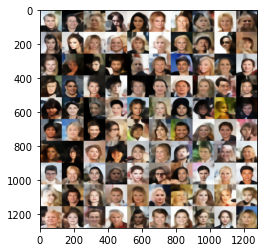

In [58]:
import matplotlib.pyplot as plt
plt.imshow(vis)